In [1]:
# Standard python imports
import os
import h5py
import numpy as np
from tqdm import tqdm, tnrange, tqdm_notebook

# Keras, tf, and sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Make reproducible
SEED = 32
np.random.seed(SEED)
tf.set_random_seed(SEED)

# My module imports
import utils
from models import model_1d

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Data Processing

In [2]:
# Maybe get the data .mat file
if not os.path.isfile("data.mat"):
    !wget https://www.dropbox.com/s/b1bnrj2f30xe1ns/xq_data_big.mat?dl=0
    !mv 'xq_data_big.mat?dl=0' data.mat

# Import the data from file
f = h5py.File("data.mat")
data, labels = np.array(f['data']), np.array(f['labels'])
f.close()

In [3]:
# Get rid of zero columns
colInds = np.sum(data, axis=0) != 0.0
data = data[:, colInds]

# Normalize
data = np.log1p(data)

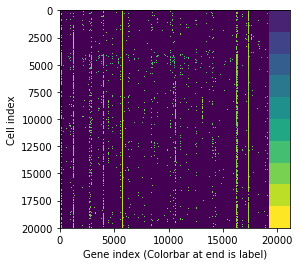

In [4]:
# Visualize data with labels
labels_scaled = labels * (data.max() - data.min()) / labels.max() - data.min()
plt.imshow(np.hstack((data, np.repeat(labels_scaled, data.shape[1] //  10, axis=1))))
plt.xlabel("Gene index (Colorbar at end is label)")
plt.ylabel("Cell index");

In [5]:
# Parameters to use for the rest of this workflow
BATCH_SIZE = 60
TEST_PROP = 0.1
VAL_PROP = 0.1
NCLASS = 10
NFEATURES = data.shape[1]

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


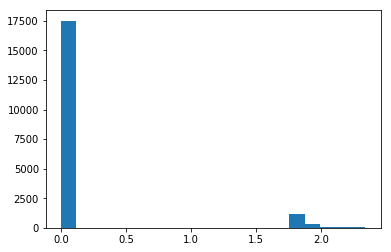

In [6]:
# Get test and training
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=TEST_PROP)

# Convert labels to one-hot format
train_labels = (np.arange(NCLASS) == train_labels).astype(np.float32)
test_labels = (np.arange(NCLASS) == test_labels).astype(np.float32)

# Sanity check to make sure data is not crazy
plt.subplot(111).hist(train_data[0].flatten(), bins=20)
print(train_labels[0])

In [7]:
# Reshape the data
test_data = test_data[:, :, None, None]
train_data = train_data[:, :, None, None]

# Model Definition

In [8]:
#model = model_1d(NFEATURES, conv_channels=[16, 16, 32, 64], dense_neurons=[512], n_class=NCLASS, \
#                 conv_ks=[10, 10, 10, 2], \
#                 pool_ks=[2, 4, 4, 12], \
#                 pads=['same', 'same', 'same', 'valid'], \
#                 dropout_strength=0.5)

model = model_1d(NFEATURES, conv_channels=[16, 16, 32, 64, 128], dense_neurons=[512], n_class=NCLASS, \
                 conv_ks=[20, 10, 10, 2, 5], \
                 pool_ks=[2, 4, 4, 4, 3], \
                 pads=['same', 'same', 'same', 'valid', 'same'], \
                 dropout_strength=0.5)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


# Training / Evaluation

In [9]:
model.fit(train_data, train_labels, 
          batch_size=BATCH_SIZE, epochs=10,\
          validation_split=0.1, verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 16200 samples, validate on 1800 samples
Epoch 1/10
16200/16200 [==============================] - 78s 5ms/step - loss: 1.0709 - acc: 0.4956 - val_loss: 0.6176 - val_acc: 0.6522
Epoch 2/10
16200/16200 [==============================] - 78s 5ms/step - loss: 0.6496 - acc: 0.6444 - val_loss: 0.5292 - val_acc: 0.6967
Epoch 3/10
16200/16200 [==============================] - 77s 5ms/step - loss: 0.5289 - acc: 0.6891 - val_loss: 0.4851 - val_acc: 0.7144
Epoch 4/10
16200/16200 [==============================] - 77s 5ms/step - loss: 0.4680 - acc: 0.7167 - val_loss: 0.4622 - val_acc: 0.7133
Epoch 5/10
16200/16200 [==============================] - 77s 5ms/step - loss: 0.4064 - acc: 0.7362 - val_loss: 0.4526 - val_acc: 0.7183
Epoch 6/10
16200/16200 [==============================] - 77s 5ms/step - loss: 0.3456 - acc: 0.7638 - v

In [10]:
loss, acc = model.evaluate(test_data, test_labels)
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")

2000/2000 [==============================] - 2s 1ms/step
Test loss: 0.5261057357788086
Test accuracy: 0.7305


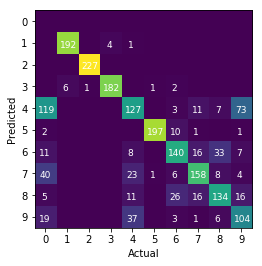

In [11]:
preds = model.predict(test_data)
conf = utils.confusions(preds, test_labels)
utils.plot_confusions(conf);

# Saving / Summary

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 19232, 1, 16)      176       
_________________________________________________________________
average_pooling2d_1 (Average (None, 4808, 1, 16)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4808, 1, 32)       5152      
_________________________________________________________________
average_pooling2d_2 (Average (None, 1202, 1, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1201, 1, 64)       4160      
_________________________________________________________________
average_pooling2d_3 (Average (None, 300, 1, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 300, 1, 128)       41088     
__________

In [13]:
fName = "test_model.h5"
model.save(fName)

# Reloading old model


In [18]:
from keras.models import load_model
model = load_model("test_model.h5")

In [19]:
loss, acc = model.evaluate(train_data, train_labels)
print(f"Train loss: {loss}")
print(f"Train accuracy: {acc}")

18000/18000 [==============================] - 21s 1ms/step
Train loss: 0.12209208594924874
Train accuracy: 0.8640555555555556


In [20]:
loss, acc = model.evaluate(test_data, test_labels)
print(f"Test loss: {loss}")
print(f"Test accuracy: {acc}")

2000/2000 [==============================] - 3s 1ms/step
Test loss: 0.5261057357788086
Test accuracy: 0.7305


# A closer look at the data

In [14]:
t_dat, t_lab = test_data.reshape(test_data.shape[:2]), np.argmax(test_labels, axis=1)

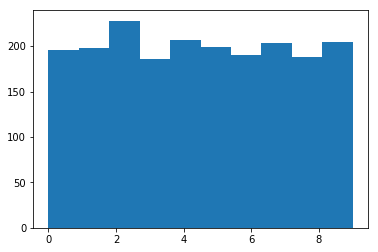

In [15]:
plt.hist(np.argmax(test_labels, axis=1));

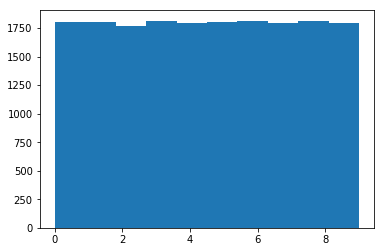

In [16]:
plt.hist(np.argmax(train_labels, axis=1));

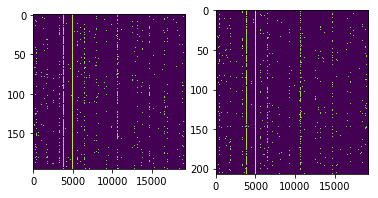

In [17]:
plt.subplot(121).imshow(t_dat[t_lab == 0], aspect=100);
plt.subplot(122).imshow(t_dat[t_lab == 4], aspect=100)